In [1]:
# Import system modules
from os.path import getsize, join
from shutil import copyfile
import matplotlib.pyplot as plt
# Import numpy
import warnings
import numpy as np
import obspy
# Local imports
from seisflows.tools.tools import iterable

In [2]:
def read_slice(path, parameters, iproc):
    """ Reads SPECFEM model slice(s)
        Such as, for example : proc000005_vp.bin
        In that specific case it would be : read_slice(path, 'vp', 5)
    """
    vals = []
    for key in parameters:
        filename = '%s/proc%06d_%s.bin' % (path, iproc, key)
        vals += [_read(filename)]
    return vals

def _read(filename):
    """ Reads Fortran style binary data into numpy array
    """
    nbytes = getsize(filename)
    with open(filename, 'rb') as file:
        # read size of record
        file.seek(0)
        n = np.fromfile(file, dtype='int32', count=1)[0]
        if n == nbytes-8:
            file.seek(4)
            data = np.fromfile(file, dtype='float32')
            return data[:-1]
        else:
            file.seek(0)
            data = np.fromfile(file, dtype='float32')
            return data

In [3]:
def readStations(path):
    """ Read specfem2d STATIONS file
    """
    with warnings.catch_warnings():  # Suppress warning about single precision
        warnings.simplefilter("ignore")
        stats = np.genfromtxt(path, usecols=(0, 2, 3), dtype=None)
    temp = [list(u) for u in stats]
    temp = map(list, zip(*temp))
    return temp[:][0], np.array(temp[:][1]), np.array(temp[:][2])

In [4]:
def readSources(path, NSRC):
    """Read specfem2d SOURCE file with standard 14 parameter
    """
    xs = []
    zs = []
    for i in range(NSRC):
        data = np.genfromtxt(path + "/SOURCE_" + str(i).zfill(6))
        temp = [list(u) for u in [data[:,2]]]
        temp = map(list, zip(*temp))
        xs += temp[1]
        zs += temp[2]
    return xs, zs

In [5]:
namesStats, xStats, zStats = readStations('./specfem2d/DATA/STATIONS')
xSources, zSources = readSources('./specfem2d/DATA/', NSRC = 15)

In [166]:
ITER = -1
#pars = ["vp_kernel"]
pars = ["vp","vs"]
NPROC = 32
if ITER is 0:
    PATH = './output/model_init/'
elif ITER is -1:
    PATH = './output/model_true/'
else:
    PATH = './output/model_' + str(ITER).zfill(4) + '/'
#PATH = './scratch/solver/000000/DATA/'

DATA = {}
for PROC in range(NPROC):
    for COORD in ['x', 'z']:
        if PROC ==0:
            DATA[COORD] = read_slice(path = './output/model_init', parameters = [COORD], iproc = PROC)
        else:
            DATA[COORD][0] = np.append(DATA[COORD][0], read_slice(path = './output/model_init', parameters = [COORD], iproc = PROC))
    for PAR in pars:
        if PROC == 0:
            DATA[PAR] = read_slice(path = PATH, parameters = [PAR], iproc = PROC)
        else:
            DATA[PAR][0] = np.append(DATA[PAR][0], read_slice(path = PATH, parameters = [PAR], iproc = PROC))
        

Text(0.5,1,'./output/model_true/ PAR: vp')

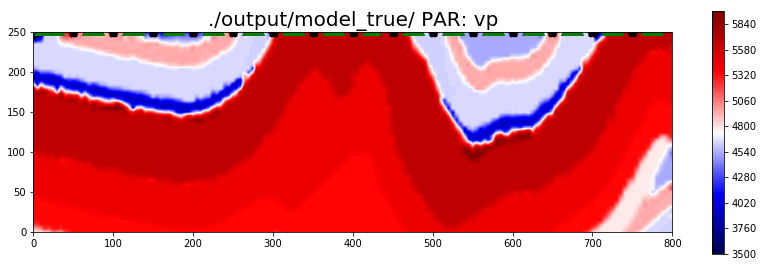

In [167]:
r = (max(DATA['x'][0]) - min(DATA['x'][0]))/(max(DATA['z'][0]) - min(DATA['z'][0]))
rx = r/np.sqrt(1 + r**2)
ry = 1/np.sqrt(1 + r**2)
plt.figure(figsize=(15*rx, 15*ry))
ax = plt.gca()
#ax.invert_yaxis()
plt.tricontourf(DATA['x'][0], DATA['z'][0], DATA['vp'][0], 125)
plt.axes().set_aspect('equal') 
plt.axis('image')
plt.colorbar(orientation='vertical')
plt.set_cmap('seismic')
plt.scatter(xStats, zStats, c='g', marker='^',linewidths=1)
plt.scatter(xSources, zSources, c='k', marker='*', linewidths=5)
plt.title(PATH + ' PAR: vp', fontsize = 20)


In [157]:
#ITER = 4
pars = ["vp_kernel"]

NPROC = 32
PATH = './output/gradient_' + str(ITER).zfill(4) + '/'
#PATH = './scratch/solver/000000/DATA/'

DATA = {}
for PROC in range(NPROC):
    for COORD in ['x', 'z']:
        if PROC ==0:
            DATA[COORD] = read_slice(path = './output/model_init', parameters = [COORD], iproc = PROC)
        else:
            DATA[COORD][0] = np.append(DATA[COORD][0], read_slice(path = './output/model_init', parameters = [COORD], iproc = PROC))
    for PAR in pars:
        if PROC == 0:
            DATA[PAR] = read_slice(path = PATH, parameters = [PAR], iproc = PROC)
        else:
            DATA[PAR][0] = np.append(DATA[PAR][0], read_slice(path = PATH, parameters = [PAR], iproc = PROC))
        

Text(0.5,1,'./output/gradient_0050/ PAR: vp')

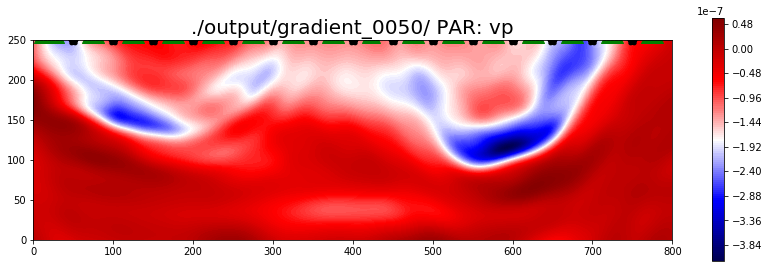

In [150]:
r = (max(DATA['x'][0]) - min(DATA['x'][0]))/(max(DATA['z'][0]) - min(DATA['z'][0]))
rx = r/np.sqrt(1 + r**2)
ry = 1/np.sqrt(1 + r**2)
plt.figure(figsize=(15*rx, 15*ry))
ax = plt.gca()
#ax.invert_yaxis()
plt.tricontourf(DATA['x'][0], DATA['z'][0], DATA['vp_kernel'][0], 125)
plt.axes().set_aspect('equal') 
plt.axis('image')
plt.colorbar(orientation='vertical')
plt.set_cmap('seismic')
plt.scatter(xStats, zStats, c='g', marker='^',linewidths=1)
plt.scatter(xSources, zSources, c='k', marker='*', linewidths=5)
plt.title(PATH + ' PAR: vp', fontsize = 20)



In [102]:
DT = 0.0002
NT = 30000

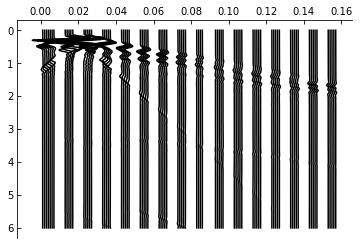

In [108]:
syn = obspy.read('./scratch/solver/000001/traces/syn/Uz_file_single.su')
syn_np = np.double(syn)
for i in range(81) :
    plt.plot(0.2e-3 * xStats[i] * np.ones(NT) + syn_np[i, :], DT * np.linspace(1, NT, NT), 'k')
    
ax_1 = plt.gca()
ax_1.invert_yaxis()
ax_1.spines['bottom'].set_color('none'); 
ax_1.spines['right'].set_color('none')
ax_1.xaxis.set_ticks_position('top')
ax_1.tick_params(direction = 'in')
plt.show()

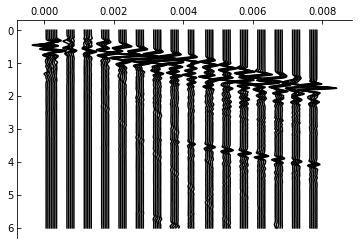

In [120]:
adj = obspy.read('./scratch/solver/000001/traces/adj/Uz_file_single.su.adj')
adj_np = np.double(adj)
for i in range(81) :
    plt.plot(1e-5 * xStats[i] * np.ones(NT) + adj_np[i, :], DT * np.linspace(1, NT, NT), 'k')
    
ax_1 = plt.gca()
ax_1.invert_yaxis()
ax_1.spines['bottom'].set_color('none'); 
ax_1.spines['right'].set_color('none')
ax_1.xaxis.set_ticks_position('top')
ax_1.tick_params(direction = 'in')
plt.show()

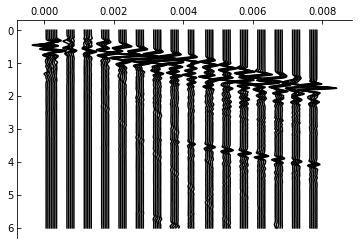

In [121]:
obs = obspy.read('./scratch/solver/000012/traces/obs/Uz_file_single.su')
obs_np = np.double(adj)
for i in range(81) :
    plt.plot(1e-5 * xStats[i] * np.ones(NT) + obs_np[i, :], DT * np.linspace(1, NT, NT), 'k')
    
ax_1 = plt.gca()
ax_1.invert_yaxis()
ax_1.spines['bottom'].set_color('none'); 
ax_1.spines['right'].set_color('none')
ax_1.xaxis.set_ticks_position('top')
ax_1.tick_params(direction = 'in')
plt.show()